In [1]:
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import matplotlib
from os.path import join
import os
from util import utils
from util.dataloader import load_data, IMUDataset
import sklearn.metrics
import scipy


path = 'C:\\Users\\Raphael\\Desktop\\Experiment2\\runs'
#path = 'C:\\Users\\Raphael\\Desktop\\Experiment2\\runs_30EPOCHS'
output_path = 'C:\\Users\\Raphael\\Desktop\\Experiment2'

# Bestandteile:
---
- Statistik über den Datensatz
- Durchschnittliche Performance (Baseline | Transformer)
- Durchschnittliche Loss-Entwicklungen 
- Absteigende Sortierung der Configs (Accuracy: Modelltyp | Fenstergröße | Normalisierung | Split_Type)
- Vergleich Transformer vs. Baseline mit gleichen Settings (Aggregieren?)
- Auswirkung der Fenstergrößen

# Funktionsdefintionen

### Hilfsfunktionen für Plots etc.
---

In [2]:
def plot_class_distr(labels, label_dict=None, file_name=None):
    if file_name is not None:
        file_name = join(file_name, 'class_distribution.png')
    
    assert labels.ndim == 1
    
    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    def autolabel(rects):
    # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 1,
                    '%d' % float(height),
                    ha='center', va='bottom')


    fig, ax = plt.subplots()
        
    if label_dict is not None:
        labels = [label_dict[label] for label in labels]
        
    labels_unique = np.unique(labels, axis=None) if isinstance (labels, np.ndarray) else list(set(labels))
    labels_count = [0] * len(labels_unique)
    
    for idx, label1  in enumerate(labels_unique):
        for label2 in labels:
            labels_count[idx] += int(label1 == label2)
    
    y_values = np.arange(len(labels_unique))

    plt.title('N = {:_}'.format(len(labels)))
    #plt.ylabel('Absolute Häufigkeit')
    #plt.xlabel("Aktivitätsklasse")

    c = ['b', 'g', 'r', 'c', 'm', '#F97306', 'y', 'k', 'tab:gray']
    c_rects = plt.bar(y_values, labels_count, align='center', alpha=0.66, color=c)
    #c_rects = plt.bar(y_values, labels_count, align='center', alpha=0.66)

    ax.set_xticks(range(len(labels_unique)))
    ax.set_xticklabels(labels_unique, rotation='vertical')

    autolabel(c_rects)

    plt.ylim(0, 400000)
    
    if file_name != None:
        plt.savefig(file_name)
        
    plt.show()
    
    plt.close('all')
    matplotlib.rc_file_defaults()

In [3]:
def plot(data, x_vals = None, title=None, x_title=None, y_titles=None, path=None):
    if x_vals is None:
        x_vals = np.array(range(len(data[0])))
    fig = plt.figure(figsize=(16, 9), dpi=120)
    for idx in range(len(data)):        
        if y_titles is not None:
            plt.plot(x_vals, data[idx], label=y_titles[idx])
        else:
            plt.plot(x_vals, data[idx])
    plt.grid()
    if y_titles is not None:
        plt.legend(loc='upper left')
    if x_title is not None:
        plt.xlabel(x_title)
    if title is not None:
        plt.title(title)
    if path is not None:
        plt.savefig(path)
    plt.show()
    
    plt.close(fig)
    matplotlib.rc_file_defaults()

In [4]:
def scatter(data, x_vals = None, title=None, x_title=None, y_title=None, y_titles=None, path=None):
    if x_vals is None:
        x_vals = np.array(range(len(data[0])))
    fig = plt.figure(figsize=(16, 9), dpi=120)
    for idx in range(len(data)):        
        if y_titles is not None:
            plt.scatter(x_vals, data[idx], label=y_titles[idx])
        else:
            plt.scatter(x_vals, data[idx])
    plt.grid()
    if y_titles is not None:
        plt.legend(loc='upper left')
    if x_title is not None:
        plt.xlabel(x_title)
    if y_title is not None:
        plt.ylabel(y_title)
    if title is not None:
        plt.title(title)
    if path is not None:
        plt.savefig(path)
    plt.show()
    
    plt.close(fig)
    matplotlib.rc_file_defaults()

In [5]:
def create_heatmap(real_labels, pred_labels, labels, label_dict=None, title=None, file_name=None , normalize=True):

    if label_dict != None:
        real_labels = [label_dict[label] for label in real_labels]
        pred_labels = [label_dict[label] for label in pred_labels]
        labels = [label_dict[label] for label in labels]
    
    confusion_matr = confusion_matrix(y_true=real_labels, y_pred=pred_labels, labels=labels)
    if normalize:
        confusion_matr = np.array(confusion_matr, dtype=np.float64)
        for row in confusion_matr:
            row *= 100 / np.sum(row)
    
    fig = plt.figure(figsize=(16, 9), dpi=120)
    sns.set_theme()
    own_cmap = sns.color_palette("viridis", as_cmap=True) #sns.color_palette("pastel", as_cmap=True)
    
    ax = sns.heatmap(confusion_matr, annot=True, fmt=".2f" if normalize else "d", cmap=own_cmap, cbar=False,
                     linewidths=.5, xticklabels=labels, yticklabels=labels)
    if normalize:
        for t in ax.texts: t.set_text(t.get_text() + "%")
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)
    
    plt.xlabel("Predicted Labels",rotation=0, fontsize=22)
    plt.ylabel("Real Labels", rotation=90, fontsize=22)
    
    
    ax.set_title(title, fontsize=22)

    if file_name != None:
        plt.savefig(file_name)
        
    plt.close(fig)
    
    matplotlib.rc_file_defaults()

In [6]:
def get_files(path, file_extension):
    file_names = []
    for root, dirs, files in os.walk(path, topdown=False):
        for file_name in files:
            if file_name.endswith(file_extension):
                file_names.append(join(root, file_name))
    return file_names

### Auswertungsfunktionen:
---

In [7]:
def eval_losses(path, plot_std=False, output_path=None):    
    
    cfg_files = get_files(path, 'config.json')
    loss_files = get_files(path, 'loss.npy')
    
    configs = []
    models = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            conf = json.load(read_file)
            configs.append(conf)
            if conf['data']['model_name'] not in models:
                models.append(conf['data']['model_name'])   
    
    shortest_run = 9999 
    for run in loss_files:
        r = np.load(run)
        shortest_run = min(shortest_run, r.shape[1]) 
    
    for model in models:
        if output_path is not None:
            output_path_ = join(output_path, 'eval_losses[{}].png'.format(model))
        else: 
            output_path_ = None
        loss = [np.load(loss)[:, :shortest_run] for config, loss in zip(configs, loss_files) if config['data']['model_name'] == model]
        loss = np.array(loss)
    
    
        # Averaging
        loss = np.average(loss, axis=0)
    
        # Printing average-accuracies
        avg_acc = np.average(loss[-1]).item()
        min_acc = np.min(loss[-1]).item()
        max_acc = np.max(loss[-1]).item()
    
        eval_str = '{}_Validationset: Min_Accuracy {:.3f} | Avg_Accuracy {:.3f} | Max_Accuracy {:.3f}'.format(model.capitalize(), min_acc, avg_acc, max_acc)
        eval_str = eval_str
        titles = ['Loss_avg', 'Val_Loss_avg', 'Val_acc']
        plot(loss[[0,1,2]], title=eval_str, x_title='Epochs', y_titles=titles, path=output_path_)

In [8]:
def eval_accuracy(path):
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
    
    configs = []
    model_names = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            cfg = json.load(read_file)
            configs.append(cfg)
            model_name = cfg['data']['model_name']
            if model_name not in model_names:
                model_names.append(model_name)
    
    for model_name in model_names:
        # Preperation
        classifications = [np.load(classifications) for config, classifications in zip(configs, classification_files) if config['data']['model_name'] == model_name]
        accuracies = []
        f1_scores = []
    
        for c in classifications:
            acc = sklearn.metrics.accuracy_score(y_true=c[0], y_pred=c[1])
            f1 = sklearn.metrics.f1_score(y_true=c[0], y_pred=c[1], average='weighted')
            accuracies.append(acc)
            f1_scores.append(f1)

        accuracies = np.array(accuracies)
        f1_scores = np.array(f1_scores)
    
        print('Validation_Result: {:15s} | Minimum_Accuracy: {:.3f} | Average_Accuracy: {:.3f} | Maximum_Accuracy: {:.3f}'.format(model_name, np.min(accuracies), np.average(accuracies), np.max(accuracies)))
        print('Validation_Result: {:15s} | Minimum_F1-Score: {:.3f} | Average_F1-Score: {:.3f} | Maximum_F1-Score: {:.3f}'.format(model_name, np.min(f1_scores), np.average(f1_scores), np.max(f1_scores)))

In [9]:
def avg_accuracies(path):
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
    classifications = [np.load(classifications) for classifications in classification_files]
    
    configs = []
    models = []
    window_sizes = []
    normalizations = []
    
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            conf = json.load(read_file)
            configs.append(conf)
            if conf['data']['model_name'] not in models:
                models.append(conf['data']['model_name'])
            if conf['data']['window_size'] not in window_sizes:
                window_sizes.append(conf['data']['window_size'])
            if conf['data']['normalize'] not in normalizations:
                normalizations.append(conf['data']['normalize'])
    
    accuracies = []
    
    for c in classifications:
        acc = sklearn.metrics.accuracy_score(y_true=c[0], y_pred=c[1])
        accuracies.append(acc)
    
    accuracies = np.array(accuracies)
    
    model_dict = {model_name: pos for pos, model_name in enumerate(models)}
    window_dict = {win: pos for pos, win in enumerate(window_sizes)}
    normalization_dict = {n: pos for pos, n in enumerate(normalizations)}
    
    N = len(model_dict) * len(window_dict) * len(normalization_dict)
    aggr_ls = [[] for _ in range(N)]
    
    for cfg, acc in zip (configs, accuracies):
        m = model_dict[cfg['data']['model_name']]
        w = window_dict[cfg['data']['window_size']]
        n = normalization_dict[cfg['data']['normalize']]
        
        m_shift = N // len(models)
        n_shift = N // (len(models) * len(normalizations))
        w_shift = N // (len(models) * len(normalizations) * len(window_sizes)) 
        
        idx = m * m_shift +  n * n_shift + w * w_shift
        
        aggr_ls[idx].append(acc)
    
    aggr_ls = np.array(aggr_ls)
    
    f_str = '|{:^15}|{:^13}|{:^13}|{:^19}|'
    split_line = f_str.format('-'*15, '-'*13,'-'*13,'-'*19)
    
    # Printing results
    print(split_line)
    print(f_str.format('Model', 'Normalize', 'Window_Size', 'Accuracy [%]'))
    print(split_line)
    
    for m in models:
        for n in normalizations:
            for w in window_sizes:
                m_shift = N // len(models)
                n_shift = N // (len(models) * len(normalizations))
                w_shift = N // (len(models) * len(normalizations) * len(window_sizes)) 

                idx = model_dict[m] * m_shift + window_dict[w] * w_shift + normalization_dict[n] * n_shift
                
                avg = np.mean(aggr_ls[idx])
                std = np.std(aggr_ls[idx])
                
                acc = '{:.2f} +-{:.2f}'.format(avg * 100, std * 100)
                print(f_str.format(m,n,w,acc))
    print(split_line)

In [10]:
def get_top_performing_configs(path, n=5):
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
        
    configs = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            configs.append(json.load(read_file))
            
    classifications = [np.load(classifications) for classifications in classification_files]
    run_names = []
    
    for c in classification_files:
        c = c.split('\\')[-1]
        c = '_'.join(c.split('_')[:-1])
        run_names.append(c)
    accuracies = []
    
    for c in classifications:
        acc = sklearn.metrics.accuracy_score(y_true=c[0], y_pred=c[1])
        accuracies.append(acc)
    
    accuracies = np.array(accuracies)
    indices = np.argsort(accuracies)
    
    config_strings = []
    
    format_str = '|{:^23}|{:^15}|{:^13}|{:^11}|{:^13}|{:^15}|{:^10}|'
    split_line = format_str.format('-' * 23, '-' * 15, '-' * 13, '-' * 11, '-' * 13, '-' * 15,'-' * 10,)
    header = format_str.format('Run', 'Accuracy [%]', 'Model', 'Normalize', 'Window', 'Split_Type', 'Seed')
    
    print(split_line)
    print(header)
    print(split_line)
    
    for i in range(-1, -(n+1), -1):
        idx = indices[i]
        name = run_names[idx]
        acc = '{:.2f}'.format(accuracies[idx].item() * 100)
        cfg = configs[idx]
        model = cfg['data']['model_name']
        normalize = cfg['data']['normalize']
        win = cfg['data']['window_size']
        split = 'P' if cfg['data']['split_type'] == 'person' else 'PR'
        seed = cfg['setup']['torch_seed']
        string = format_str.format(name, acc, model, normalize, win, split, seed)
        print(string)
        
    print(split_line)


In [11]:
def eval_window_sizes(path, output_path=None):
    if output_path is not None:
        output_path = join(output_path, 'eval_window_sizes.png')
    
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
    
    configs = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            configs.append(json.load(read_file))
            
    classifications = [np.load(classifications) for classifications in classification_files]
    accuracies = []
    models = []
    models_unique = []
    window_sizes = []
    windows_unique = []
    
    for idx in range(len(classifications)):
        classification = classifications[idx]
        cfg = configs[idx]
        
        acc = sklearn.metrics.accuracy_score(y_true=classification[0], y_pred=classification[1])
        accuracies.append(acc)
        
        model = cfg['data']['model_name']
        models.append(model)
        if model not in models_unique:
            models_unique.append(model)
        
        win = cfg['data']['window_size']
        window_sizes.append(win)
        if win not in windows_unique:
            windows_unique.append(win)
    
    
    model_dict = {model_name: pos for model_name, pos in zip(models_unique, range(len(models_unique)))}
    window_dict = {win: pos for win, pos in zip(windows_unique, range(len(windows_unique)))}
    
    aggr_array = np.zeros(shape=(len(model_dict), len(window_dict), 2), dtype=np.float32)
    
    for m, w, a in zip(models, window_sizes, accuracies):
        i = model_dict[m]
        j = window_dict[w]
        aggr_array[i,j,0] += 1
        aggr_array[i,j,1] += a
    
    y_titles = []
    y_values = []
        
    for m in models_unique:
        ls = []
        for w in windows_unique:
            m_idx = model_dict[m]
            w_idx = window_dict[w]
            
            cnt = aggr_array[m_idx,w_idx,0]
            acc = aggr_array[m_idx,w_idx,1]
            ls.append(acc / cnt)
        y_values.append(ls)
        y_titles.append(m)
        
    x_values = windows_unique
    scatter(y_values, x_vals = x_values, title='', x_title='Window_Sizes', y_titles=y_titles, path=output_path)

In [12]:
def configs_eq(config_ls):
    for idx in range(1, len(config_ls)):
        cfg1 = config_ls[idx-1]
        cfg2 = config_ls[idx]
        cfg1['data']['model_name'] = ''
        cfg2['data']['model_name'] = ''
        if cfg1['data'] != cfg2['data'] or cfg1['training'] != cfg2['training'] or cfg1['setup'] != cfg2['setup']:            
            return False
    return True

def compare_models(path, output_path=None):    
    
    if output_path is not None:
        output_path = join(output_path, 'compare_models.png')
    
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
    
    configs = []
    models = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            conf = json.load(read_file)
            configs.append(conf)
            if conf['data']['model_name'] not in models:
                models.append(conf['data']['model_name'])
                
    model_dict = {m: pos for m, pos in zip(models, range(len(models)))}
    model_dict_rev = {y: x for x,y in model_dict.items()}
    
    
    classifications = [np.load(classifications) for classifications in classification_files]
    n_classifications = len(classifications)
    n_models = len(models)
    classifications_per_model = len(classifications) // n_models
    
    y_values = []
    y_titles = []
       
    for idx in range(classifications_per_model):
        cfgs = []
        accuracies = np.zeros(len(models))
        for model in models:
            m_id = model_dict[model]
            effective_idx = m_id * classifications_per_model + idx
                        
            classification = classifications[effective_idx]
            cfgs.append(configs[effective_idx])
            
            acc = sklearn.metrics.accuracy_score(y_true=classification[0], y_pred=classification[1])
            accuracies[m_id] = acc
        
        assert configs_eq(cfgs)
        y_values.append(accuracies)
        
    y_titles = models
    y_values = np.array(y_values).transpose()
    
    scatter(y_values, x_vals=None, title='Model_Comparison', x_title='Setting_ID', y_title='Accuracy', y_titles=y_titles, path=output_path)

In [13]:
import math
def normalize_effect(path):
    cfg_files = get_files(path, 'config.json')
    classification_files = get_files(path, 'classifications.npy')
    classifications = [np.load(classifications) for classifications in classification_files]
    
    configs = []
    for cfg in cfg_files:
        with open(cfg, "r") as read_file:
            configs.append(json.load(read_file))
    
    normalized = []
    unnormalized = []
    
    for idx in range(len(classifications)):
        classification = classifications[idx]
        acc = sklearn.metrics.accuracy_score(y_true=classification[0], y_pred=classification[1])
        
        if configs[idx]['data']['normalize']:
            normalized.append(acc)
        else:
            unnormalized.append(acc)
    
    assert len(normalized) == len(unnormalized)
    
    normalized = np.array(normalized)
    unnormalized = np.array(unnormalized)
    t_test = scipy.stats.ttest_ind(normalized,
                              unnormalized,
                              equal_var=False)
    print(t_test)
    print(scipy.stats.wilcoxon(normalized, unnormalized, alternative='greater'))

# Auswertung
---

### Klassenverteilung im originalen Datensatz

In [14]:
#_, labels, _, label_dict = load_data('D:\\transformer_dir', 'lara')
#labels = labels.flatten()

#plot_class_distr(labels, label_dict, output_path)

### Klassenverteilung nach Aufbereitung des Datensatzes und Einteilung in Fenster

In [15]:
#features, labels, infos, label_dict = load_data('D:\\transformer_dir', 'lara')
#labels = labels.flatten()

#window_size = 50
#window_shift = 1

#dataset = IMUDataset(features, labels, infos, window_size, window_shift, False)

#labels = np.array([label for _, label in dataset])

#plot_class_distr(labels, label_dict, None)

 ### Durchschnittliche Loss-Entwicklung, nach Modelltyp aufgeteilt

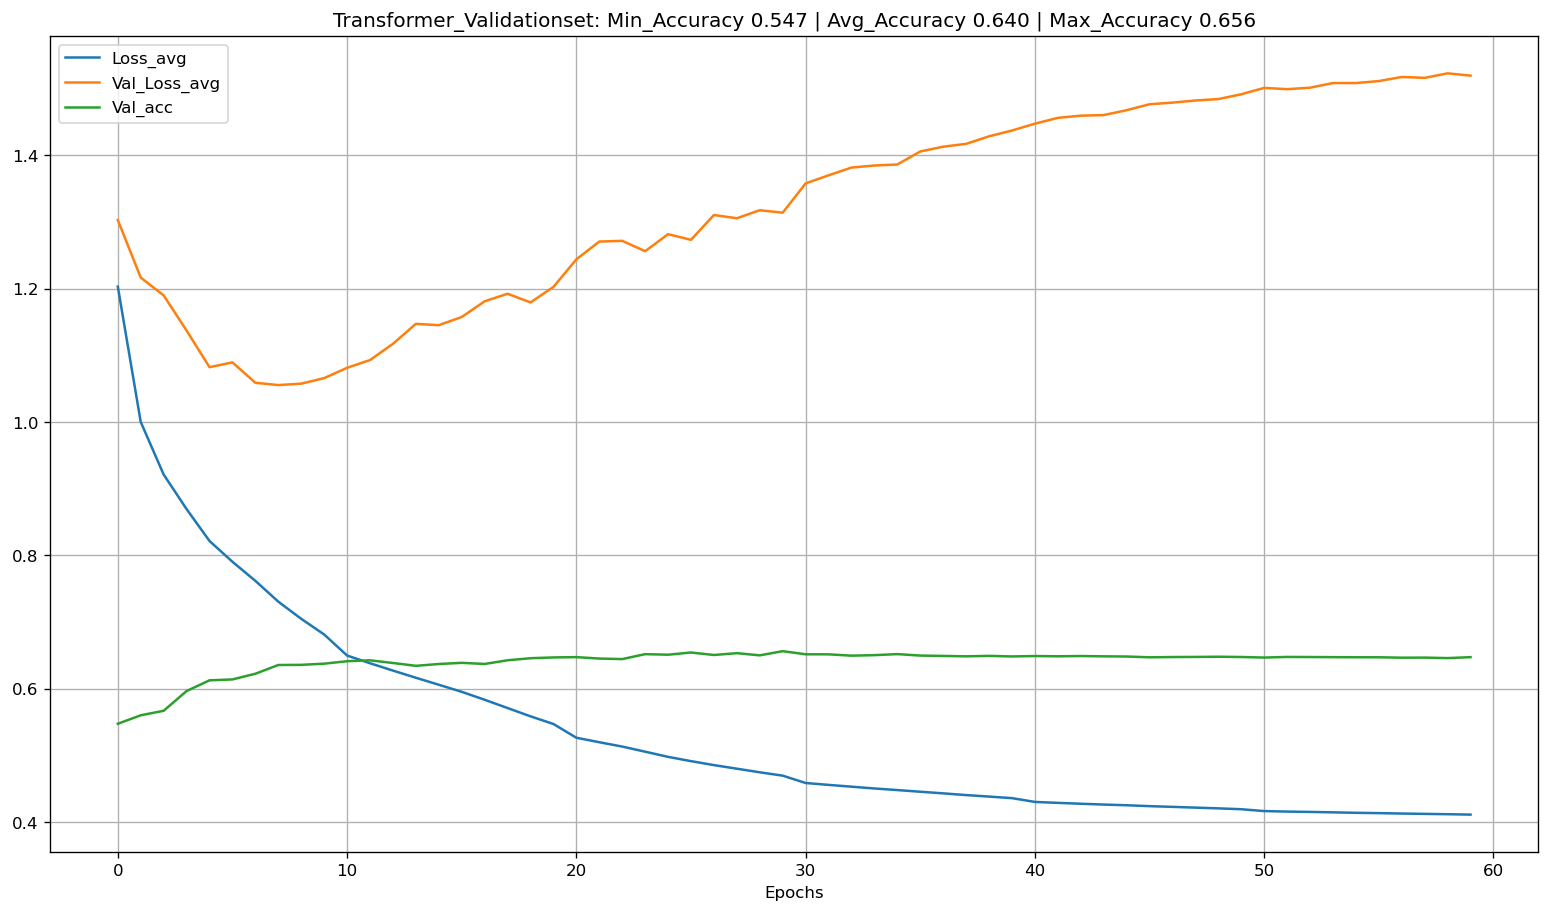

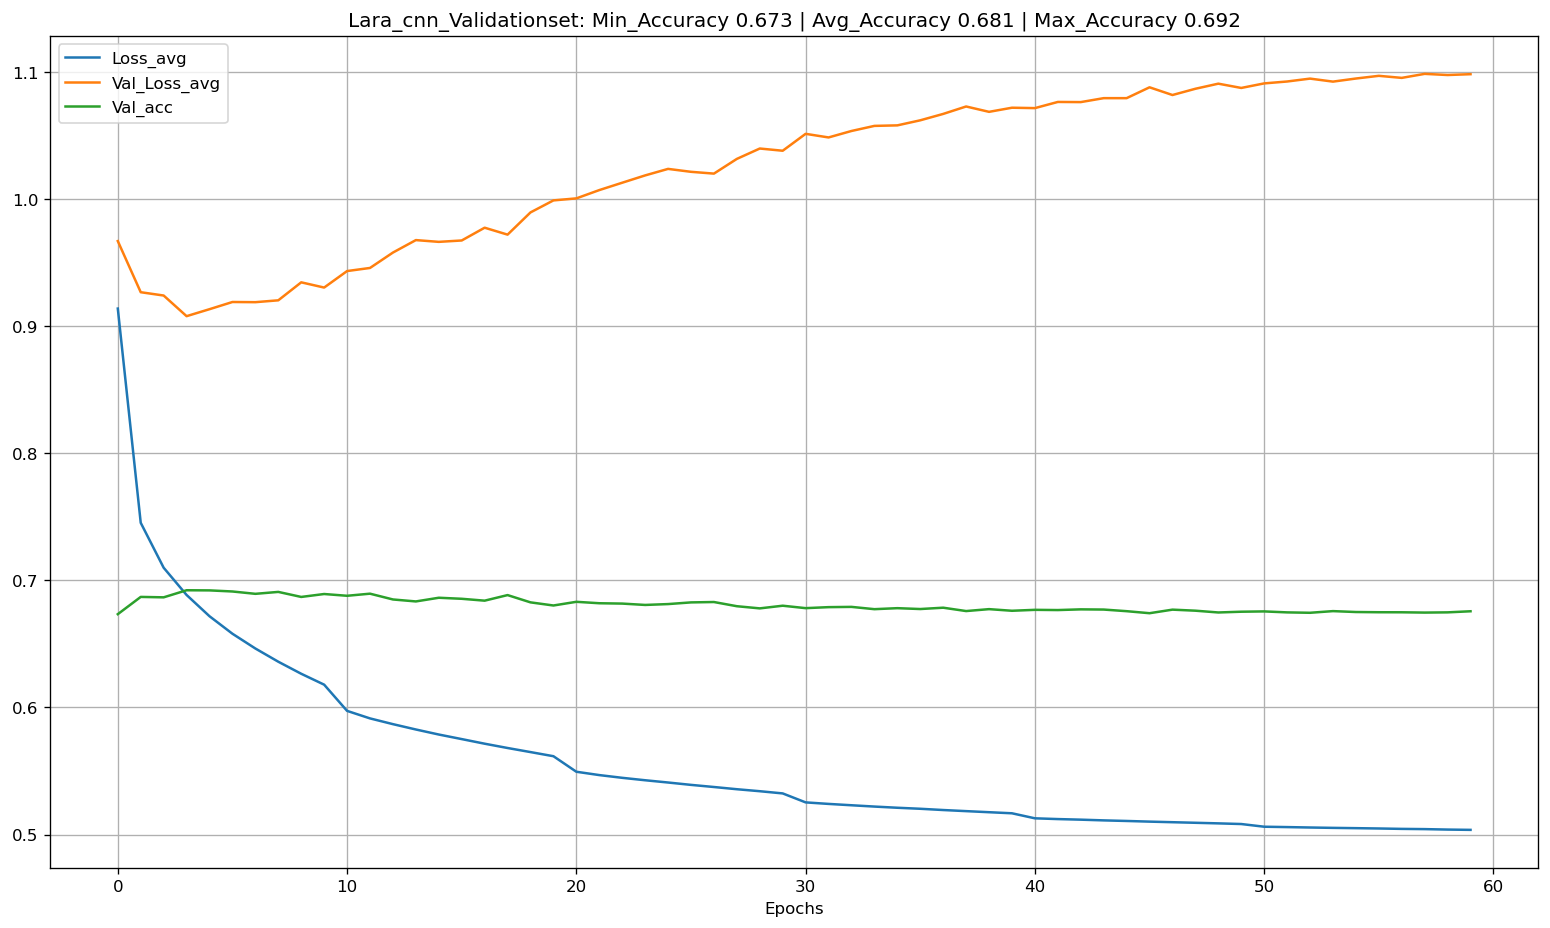

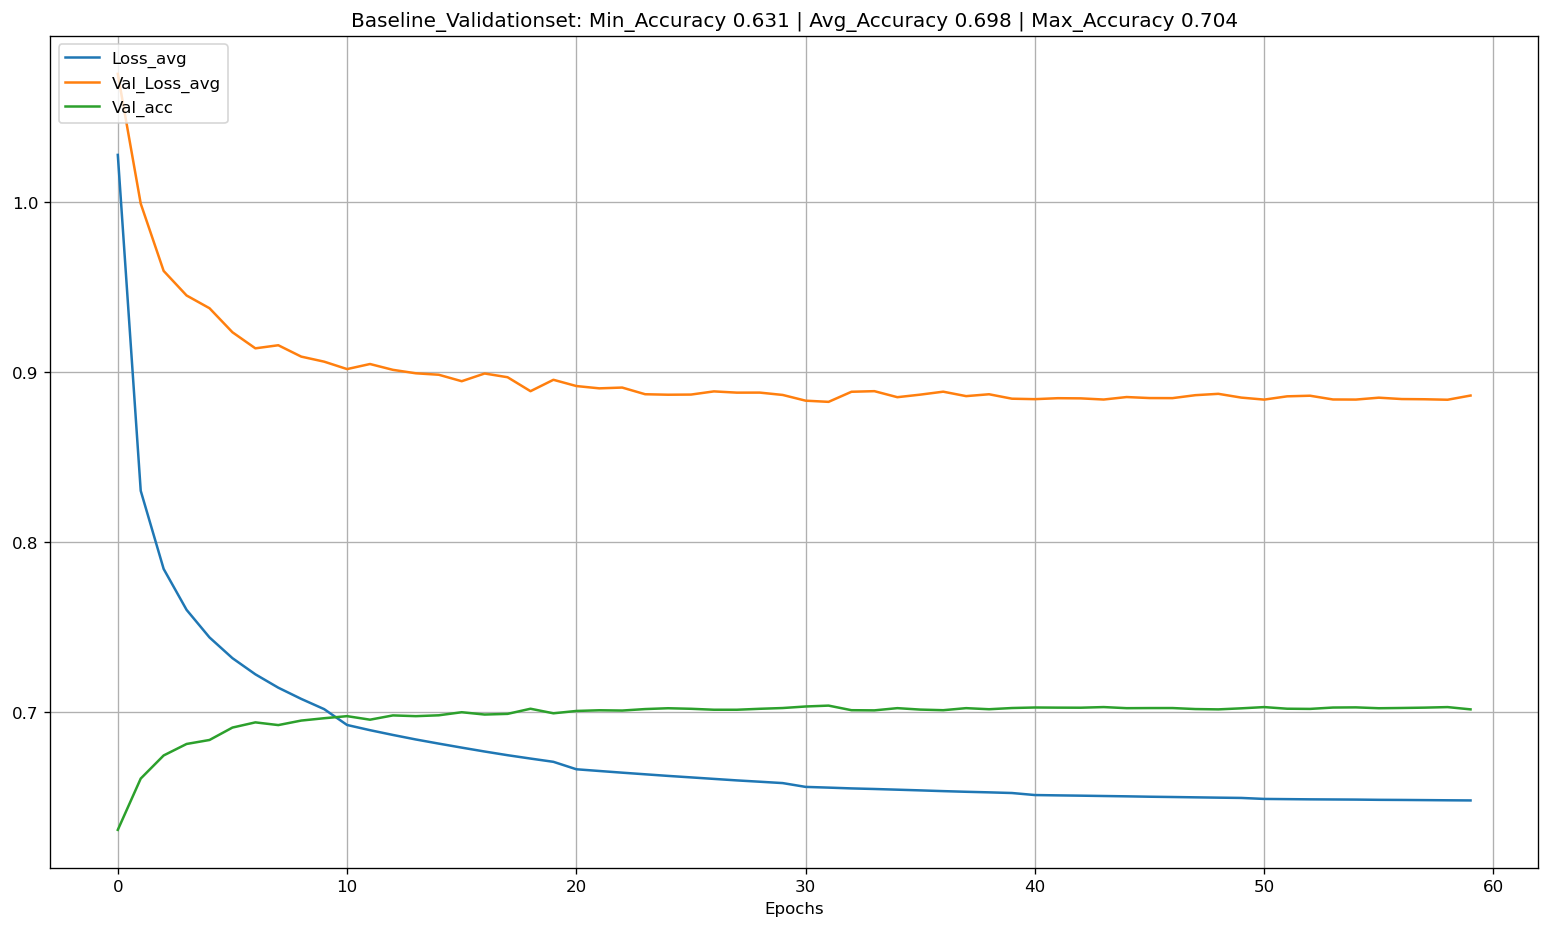

In [16]:
eval_losses(path, False, output_path)

In [17]:
avg_accuracies(path)

|---------------|-------------|-------------|-------------------|
|     Model     |  Normalize  | Window_Size |   Accuracy [%]    |
|---------------|-------------|-------------|-------------------|
|  transformer  |      1      |     24      |   69.85 +-0.46    |
|  transformer  |      1      |     50      |   68.47 +-1.41    |
|  transformer  |      1      |     100     |   66.88 +-1.38    |
|   lara_cnn    |      1      |     24      |   71.20 +-0.68    |
|   lara_cnn    |      1      |     50      |   71.69 +-0.57    |
|   lara_cnn    |      1      |     100     |   70.77 +-0.97    |
|   baseline    |      1      |     24      |   70.78 +-0.45    |
|   baseline    |      1      |     50      |   72.75 +-0.34    |
|   baseline    |      1      |     100     |   74.54 +-0.33    |
|---------------|-------------|-------------|-------------------|


### Konfigurationsmöglichkeiten auswerten

In [18]:
eval_accuracy(path)

Validation_Result: transformer     | Minimum_Accuracy: 0.652 | Average_Accuracy: 0.684 | Maximum_Accuracy: 0.706
Validation_Result: transformer     | Minimum_F1-Score: 0.653 | Average_F1-Score: 0.676 | Maximum_F1-Score: 0.691
Validation_Result: lara_cnn        | Minimum_Accuracy: 0.695 | Average_Accuracy: 0.712 | Maximum_Accuracy: 0.726
Validation_Result: lara_cnn        | Minimum_F1-Score: 0.683 | Average_F1-Score: 0.700 | Maximum_F1-Score: 0.715
Validation_Result: baseline        | Minimum_Accuracy: 0.704 | Average_Accuracy: 0.727 | Maximum_Accuracy: 0.750
Validation_Result: baseline        | Minimum_F1-Score: 0.679 | Average_F1-Score: 0.709 | Maximum_F1-Score: 0.737


In [19]:
get_top_performing_configs(path, n=50)

|-----------------------|---------------|-------------|-----------|-------------|---------------|----------|
|          Run          | Accuracy [%]  |    Model    | Normalize |   Window    |  Split_Type   |   Seed   |
|-----------------------|---------------|-------------|-----------|-------------|---------------|----------|
|  2021_12_29_03_14_16  |     74.96     |  baseline   |     1     |     100     |      PR       |    42    |
|  2021_12_29_00_59_26  |     74.71     |  baseline   |     1     |     100     |       P       |    42    |
|  2021_12_29_04_01_04  |     74.71     |  baseline   |     1     |     100     |      PR       |   1337   |
|  2021_12_29_00_15_26  |     74.63     |  baseline   |     1     |     100     |       P       |    0     |
|  2021_12_29_02_27_25  |     74.34     |  baseline   |     1     |     100     |      PR       |    0     |
|  2021_12_29_01_43_20  |     73.92     |  baseline   |     1     |     100     |       P       |   1337   |
|  2021_12_28_21_22

### Entwicklung nach Fenstergröße

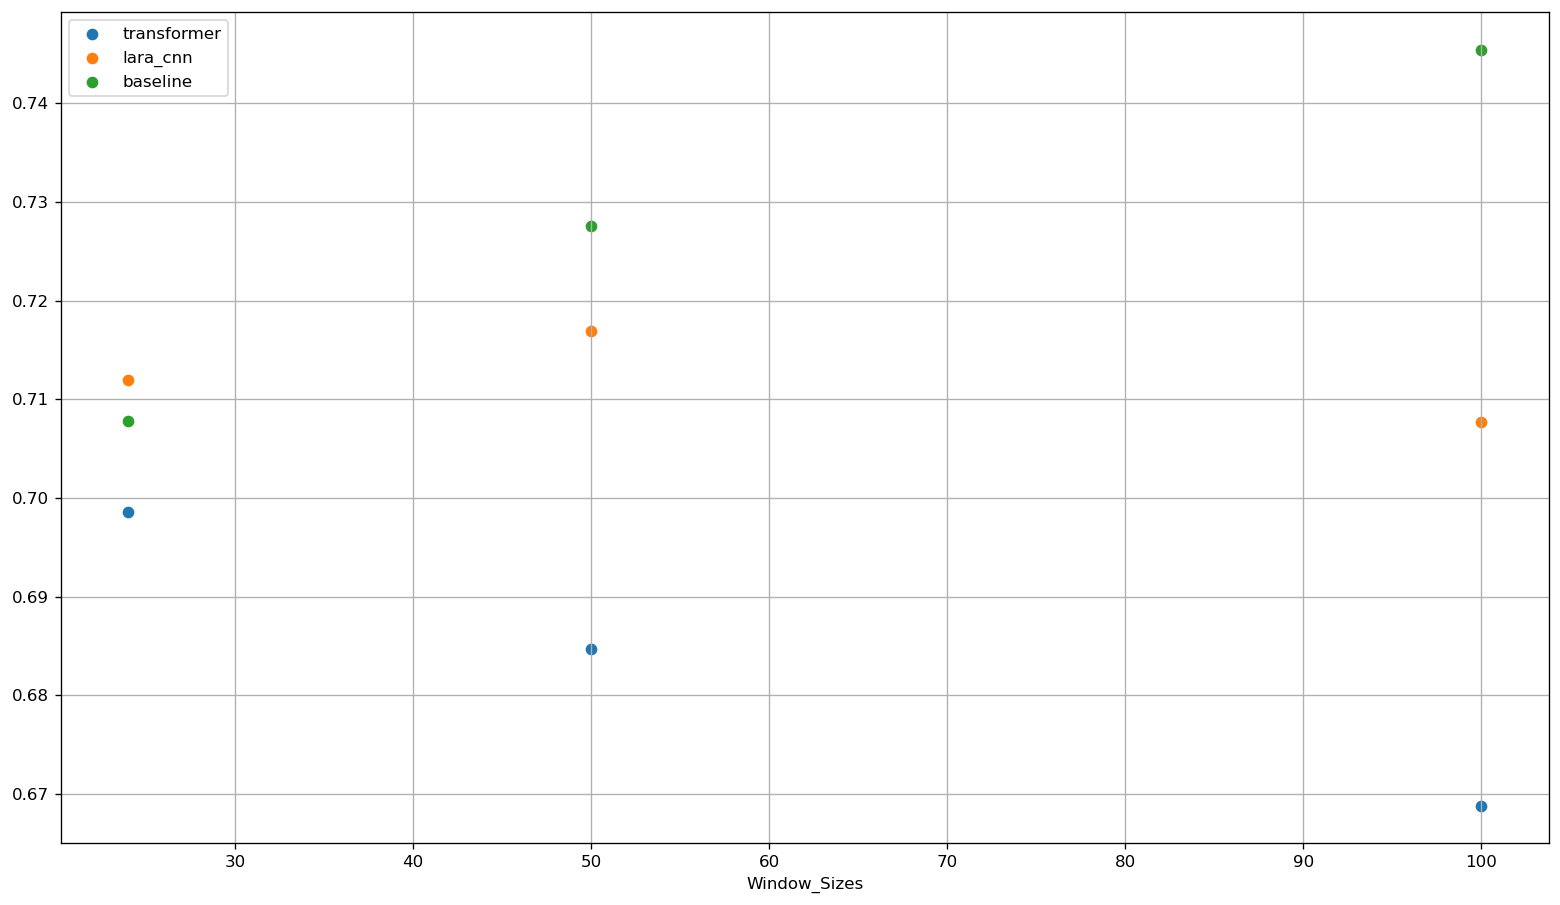

In [20]:
eval_window_sizes(path, output_path)

### Direktvergleich von Transformer vs. Baseline mit identischen Settings

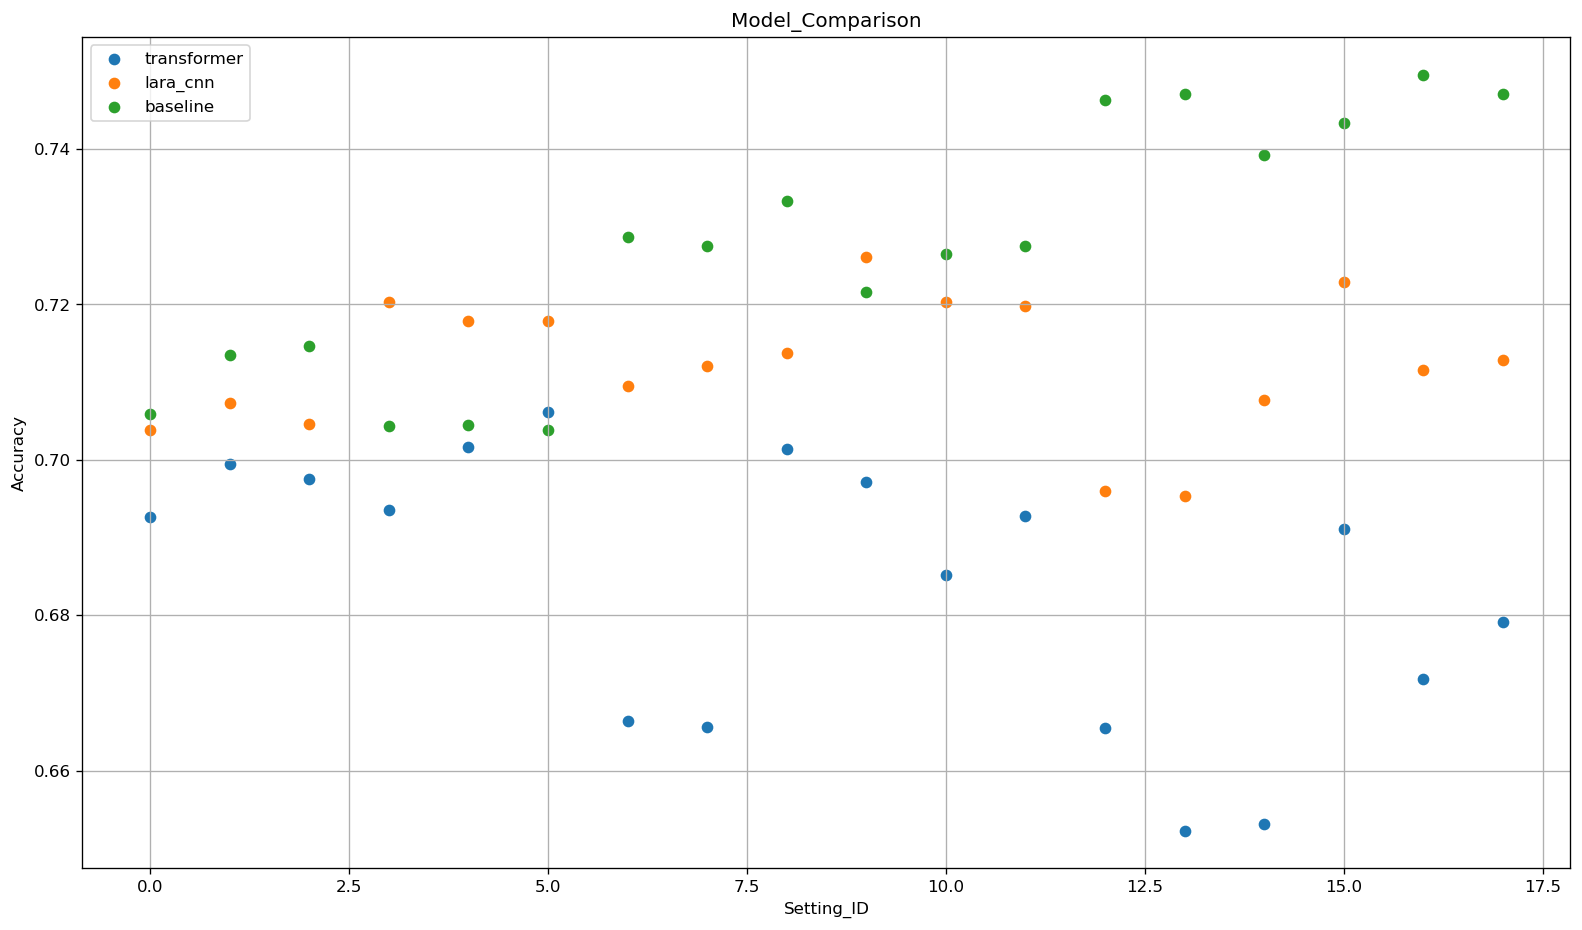

In [21]:
compare_models(path, output_path)

In [22]:
#pth = 'C:\\Users\\Raphael\\Desktop\\Experiment1\\Window_Size_Evaluation\\runs'
#eval_window_sizes(pth, None)